In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data


In [5]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"

config = Configuration.load_json(CONFIG_FILE)
# !pip install autokeras
# !pip install --upgrade scipy==1.7.0
# !pip install auto-sklearn
import autokeras as ak
# from autosklearn.classification import AutoSklearnClassifier
# from autosklearn.regression import AutoSklearnRegressor

## Read the extracted features from the CSV

In [13]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df

Number of Audio Files: 10039


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_F012,improvised,Female,2.750,angry,0,2.0,3.5,3.5,0.296270,0.082856,...,39.327560,-40.651329,42.375973,19.492970,19.512123,18.821735,47.666279,51.472340,-18.892769,-27.943581
Ses01F_impro04_F028,improvised,Female,2.010,angry,0,2.0,3.5,3.5,0.319851,0.086560,...,62.818893,-40.228039,84.092949,24.274593,11.059961,36.497154,29.247034,61.287384,-17.456673,-15.254041
Ses01F_impro04_F029,improvised,Female,3.160,angry,0,1.5,4.0,4.0,0.298296,0.085880,...,29.858166,-33.455795,164.847565,34.833263,22.882631,33.635147,118.356186,128.460770,-32.842518,-12.516586
Ses01F_impro04_F030,improvised,Female,3.185,angry,0,1.5,3.5,4.0,0.316109,0.106300,...,48.537384,-38.774422,178.178299,24.138340,11.319570,35.046803,183.465393,119.128494,-13.127378,-24.713459
Ses01F_impro04_F031,improvised,Female,4.400,angry,0,1.5,3.0,3.5,0.314387,0.065918,...,44.125771,-49.090309,100.364433,35.686844,29.594337,11.990172,68.253944,51.992161,-20.573139,-20.019981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses05M_script03_2_M013,scripted,Male,9.340,other,10,2.0,3.5,4.0,0.314951,0.063627,...,58.600712,-46.007534,113.818436,32.636822,28.463696,25.335880,78.160225,66.925186,-27.014687,-21.044426
Ses05M_script03_2_M014,scripted,Male,4.150,other,10,1.5,3.5,4.0,0.315053,0.067145,...,73.493271,-54.896301,162.575638,31.630028,12.225033,33.560890,87.977707,42.288971,-24.003210,-19.897762
Ses05M_script03_2_M018,scripted,Male,2.170,other,10,3.5,3.0,3.0,0.302163,0.062219,...,51.708046,-34.321487,181.688660,23.869041,14.644627,14.957552,41.870499,43.103497,-20.033688,-19.955128


## Data used in SOA models

In [15]:
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
data = df.iloc[:,8:]
categorical_labels = np.ravel(df.iloc[:,4:5].values)
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


# Categorical Problem (anger, happiness (+ excited), neutral, sadness)

## Models

### Simple Random Forests

In [ ]:
def plot_cm_predictions(model, input_data, labels, cv=5, draw_corr_matrix=True, verbose=1, n_jobs=8):
    y_pred = cross_val_predict(model, input_data, labels, cv=cv, verbose=verbose, n_jobs=n_jobs)

    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero one loss: ", metrics.zero_one_loss(labels, y_pred))
    print("mean absolute error: ", metrics.mean_absolute_error(labels, y_pred))

    print(metrics.classification_report(labels, y_pred))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0)
        plt.show()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   30.1s finished


accuracy:  0.4952088229976496
f1 score macro:  0.5128402898669654
f1 score micro:  0.4952088229976496
precision score:  0.5235160408175284
recall score:  0.5050289689027115
hamming loss:  0.5047911770023504
matthews corrcoef:  0.31341736401352394
zero one loss:  0.5047911770023503
mean absolute error:  0.7868378231784487
              precision    recall  f1-score   support

           0       0.64      0.54      0.58      1103
           1       0.41      0.45      0.42      1636
           2       0.60      0.57      0.58      1084
           3       0.45      0.47      0.46      1708

    accuracy                           0.50      5531
   macro avg       0.52      0.51      0.51      5531
weighted avg       0.50      0.50      0.50      5531



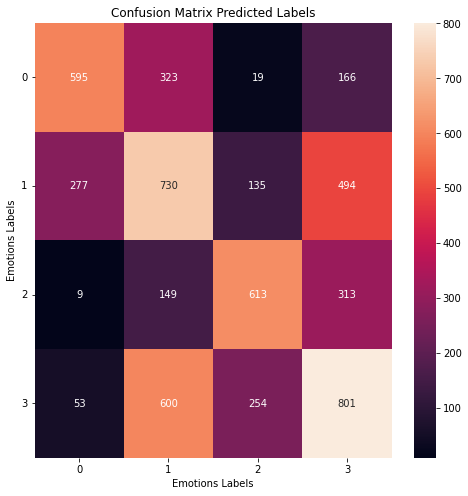

In [ ]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data.values, categorical_labels)

### AutoSKlearn

In [ ]:
model = AutoSklearnClassifier(
    max_models_on_disc=None,
    resampling_strategy='cv',
    resampling_strategy_arguments={'cv': {'folds': 5}},
    seed=1,
    n_jobs=-1
)
model.fit(data.values, categorical_labels)

AutoSklearnClassifier(max_models_on_disc=None, n_jobs=-1,
                      per_run_time_limit=720, resampling_strategy='cv',
                      resampling_strategy_arguments={'cv': {'folds': 5},
                                                     'folds': 5})

In [ ]:
print(model.sprint_statistics())

auto-sklearn results:
  Dataset name: af569de4-f17d-11ec-8351-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.606400
  Number of target algorithm runs: 39
  Number of successful target algorithm runs: 31
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 1



In [ ]:
model.show_models()

{2: {'cost': 0.3957693003073585,
  'ensemble_weight': 0.02,
  'estimators': [{'balancing': Balancing(random_state=1),
    'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f20de5b2550>,
    'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f20e7116a90>,
    'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f20de5b2750>,
    'sklearn_classifier': RandomForestClassifier(max_features=4, n_estimators=512, n_jobs=1,
                           random_state=1, warm_start=True)},
   {'balancing': Balancing(random_state=1),
    'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f20dc394b90>,
    'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f20dc384310>,
    'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice

In [ ]:
model.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
24,1,0.02,gradient_boosting,0.393600,62.607876
2,2,0.02,random_forest,0.395769,93.652015
19,3,0.04,random_forest,0.399747,147.364214
17,4,0.08,lda,0.402097,67.067775
5,5,0.02,gradient_boosting,0.407702,22.090618
25,6,0.02,gradient_boosting,0.414572,73.311230
16,7,0.04,random_forest,0.415115,98.022274
27,8,0.06,lda,0.453083,17.005109
8,9,0.02,passive_aggressive,0.483818,7.822896


#### Testing the Highest Ranked Model from the Auto Keras

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   10.2s finished


accuracy:  0.4926776351473513
f1 score macro:  0.5109447063089536
f1 score micro:  0.4926776351473513
precision score:  0.5225208539031851
recall score:  0.5032333491043759
hamming loss:  0.5073223648526487
matthews corrcoef:  0.3107950614540945
zero one loss:  0.5073223648526487
mean absolute error:  0.7909962032182245
              precision    recall  f1-score   support

           0       0.66      0.56      0.60      1103
           1       0.40      0.47      0.43      1636
           2       0.58      0.55      0.56      1084
           3       0.46      0.44      0.45      1708

    accuracy                           0.49      5531
   macro avg       0.52      0.50      0.51      5531
weighted avg       0.50      0.49      0.50      5531



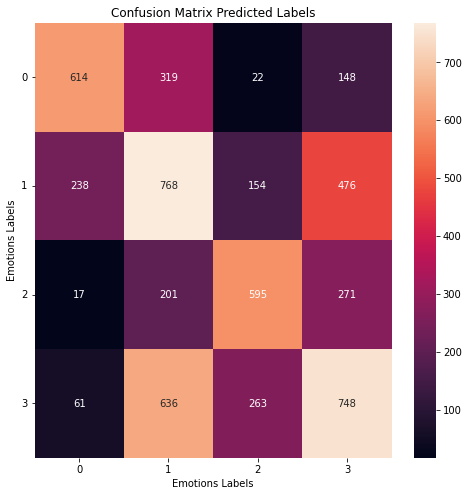

In [16]:
plot_cm_predictions(HistGradientBoostingClassifier(early_stopping=False,
                        l2_regularization=2.188553300996835e-10,
                        learning_rate=0.06138190336151616, max_iter=512,
                        max_leaf_nodes=20, n_iter_no_change=0,
                        random_state=1, validation_fraction=None,
                        warm_start=True), data.values, categorical_labels)

### Convolution Neural Networks

In [4]:
def build_model_0(input_shape=(24, 1), loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    if loss.__class__ == SparseCategoricalCrossentropy().__class__:
        n_labels = 4
        metrics = ['accuracy']
        activation = 'softmax'
    else:
        n_labels = 3
        metrics = ['mae']
        activation = 'relu'

    model = Sequential()
    model.add(Conv1D(256, (5), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(n_labels, strides=1))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(n_labels))

    model.add(Activation(activation))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
build_model_0(input_shape=(data.iloc[0].shape[0],1)).summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d (Conv1D)             (None, 20, 256)           1536      Y          
                                                                            
 batch_normalization (BatchN  (None, 20, 256)          1024      Y          
 ormalization)                                                              
                                                                            
 activation (Activation)     (None, 20, 256)           0         Y          
                                                                            
 conv1d_1 (Conv1D)           (None, 16, 128)           163968    Y          
                                                                            
 activation_1 (Activation)   (None, 16, 128)           0         Y          
                                                        

In [90]:
def categorical_cross_validation(callbacks, no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df.iloc[:,8:]
  y = df.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = build_model_0(input_shape=(data.shape[1], 1), loss=loss, optimizer=optimizer)
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=callbacks,
                workers=4)

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [ ]:
callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 500 # try 300 or 700
batch_size = 16 # try 16
learning_rate=1e-5 # try 1e-4
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 0
num_folds = 5

categorical_cross_validation(callback, no_epochs, batch_size, loss, optimizer, verbosity, num_folds)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.111961007118225; accuracy of 49.232158064842224%
Training for fold 2 ...
Score for fold 2: loss of 1.1252243518829346; accuracy of 48.73417615890503%
Training for fold 3 ...
Score for fold 3: loss of 1.1336780786514282; accuracy of 46.473780274391174%
Training for fold 4 ...
Score for fold 4: loss of 1.1383367776870728; accuracy of 46.383363008499146%
Training for fold 5 ...
Score for fold 5: loss of 1.1080365180969238; accuracy of 48.19168150424957%
------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 1.111961007118225 - Accuracy: 49.232158064842224%
> Fold 2 - Loss: 1.1252243518829346 - Accuracy: 48.73417615890503%
> Fold 3 - Loss: 1.1336780786514282 - Accuracy: 46.473780274391174%
> Fold 4 - Loss: 1.1383367776870728 - Accuracy: 46.383363008499146%
> Fold 5 - Loss: 1.1080365180969238 - Accuracy: 48.19168150424

### AutoKeras

In [ ]:
def categorical_cross_validation2(no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df.iloc[:,8:]
  y = df.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = ak.StructuredDataClassifier(overwrite=True, max_trials=100, seed=1, directory=f"best_regression_keras_model_fold_{fold_no}")
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[EarlyStopping()],
                workers=8)
  
    print(model.export_model().summary())

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

# classifier that tries 100 different keras classifier models
no_epochs = 500 # try 300 or 700
batch_size = 16 # try 16
learning_rate=1e-5 # try 1e-4
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 1
num_folds = 5

categorical_cross_validation2(no_epochs, batch_size, loss, optimizer, verbosity, num_folds)

Trial 84 Complete [00h 00m 03s]
val_accuracy: 0.13287514448165894

Best val_accuracy So Far: 0.743413507938385
Total elapsed time: 00h 05m 42s
INFO:tensorflow:Oracle triggered exit
Epoch 1/500
277/277 [==============================] - 1s 2ms/step - loss: 1.6184 - accuracy: 0.2493
Epoch 2/500
277/277 [==============================] - 1s 2ms/step - loss: 1.6064 - accuracy: 0.2522
Epoch 3/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5952 - accuracy: 0.2592
Epoch 4/500
277/277 [==============================] - 0s 2ms/step - loss: 1.5787 - accuracy: 0.2615
Epoch 5/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5554 - accuracy: 0.2712
Epoch 6/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5569 - accuracy: 0.2748
Epoch 7/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5372 - accuracy: 0.2843
Epoch 8/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5279 - accuracy: 0.2800
Epoch 9/500

#### Testing with Best Model

In [19]:
def categorical_cross_validation4(model, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1

  X = df.iloc[:,8:]
  y = df.iloc[:,4:5]

  for train, test in kfold.split(X, y):    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    y_test = y_test.astype('str')
    y_test = OneHotEncoder().fit_transform(y_test).toarray()
    print(y_test)

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [20]:
model = tf.keras.models.load_model(f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/categorical_keras_model_fold_2/structured_data_classifier/best_model", custom_objects=ak.CUSTOM_OBJECTS)
model.summary()
categorical_cross_validation4(model, 1, 5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 24)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               3200      
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                2064  

## Mel-Spectogram as the Input Feature

In [21]:
raw_df = pd.read_csv(RAW_AUDIO_FILES)
print(f"Number of Audio Files: {raw_df.shape[0]}")
raw_df = raw_df.set_index('File')
raw_df_soa = raw_df[raw_df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
raw_df_soa.loc[raw_df_soa['Emotion'] == 'excited', 'Emotion'] = 'happy'
raw_df_soa.loc[raw_df_soa['Emotion_Id'] == 5, 'Emotion_Id'] = 1
raw_df_soa.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 10039


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

def get_signal_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')
    # for windows:
    # audio_file = f"/Users/mario/{audio_file[16:]}".replace("\\", "/")

    # Zero-padding for an audio waveform with less than 5 seconds.
    input_len = sr * 5
    y = y[:input_len]
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
    
    return y, raw_df_soa.loc[audio_file]["Emotion_Id"]

def data_loader(filename):
    features, labels = tf.py_function(get_signal_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [80000, 1]), tf.reshape(labels, [1])

def preprocess_dataset(files):
  # mac
  filenames_ds = tf.data.Dataset.list_files([str(file) for file in files.index.values])
  # windows
  # filenames_ds = tf.data.Dataset.list_files([f"C:\\Users\\Chico\\{str(file)[12:]}" for file in files.index.values])

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

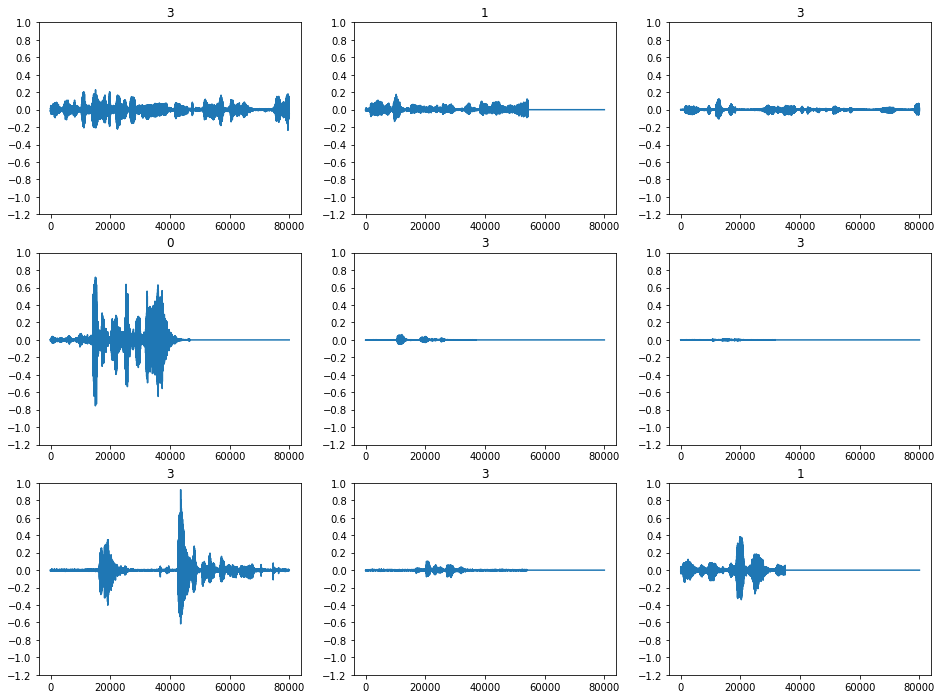

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for i, (audio, label) in enumerate(preprocess_dataset(raw_df_soa).take(9)):
  r = i // 3
  c = i % 3
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy()[0]
  ax.set_title(label)

plt.show()

In [34]:
def build_model_1(input_shape=[80000, 1], activation = 'softmax', 
                  metrics = ['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=Adam(learning_rate=1e-5, epsilon=1e-6), n_labels = 4):

    model = Sequential()

    model.add(Conv1D(128, (3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling1D(n_labels))
    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dropout(0.2))

    model.add(Dense(n_labels))

    model.add(Activation(activation))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
build_model_1().summary(show_trainable=True)

Model: "sequential_7"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d_7 (Conv1D)           (None, 79998, 128)        512       Y          
                                                                            
 batch_normalization_7 (Batc  (None, 79998, 128)       512       Y          
 hNormalization)                                                            
                                                                            
 activation_19 (Activation)  (None, 79998, 128)        0         Y          
                                                                            
 max_pooling1d_6 (MaxPooling  (None, 19999, 128)       0         Y          
 1D)                                                                        
                                                                            
 dropout_12 (Dropout)        (None, 19999, 128)       

In [35]:
def categorical_cross_validation3(callback, no_epochs, batch_size, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = raw_df_soa.iloc[:]
  y = raw_df_soa.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = build_model_1()
    
    X_train, X_test = X.iloc[train], X.iloc[test]

    train_ds = preprocess_dataset(X_train)
    train_ds = train_ds.batch(8)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    test_ds = preprocess_dataset(X_test)
    test_ds = test_ds.batch(8)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    history = model.fit(train_ds,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[callback],
                workers=8)

    scores = model.evaluate(test_ds, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

no_epochs = 20
batch_size = 16

callback = EarlyStopping(monitor='loss', patience=10)

verbosity = 1
num_folds = 3

categorical_cross_validation3(callback, no_epochs, batch_size, verbosity, num_folds)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20


/usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


  4/461 [..............................] - ETA: 1:01:57 - loss: 2.9678 - accuracy: 0.2500

KeyboardInterrupt: 